In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
df=pd.read_csv('/content/drive/MyDrive/NUS_GAIP_GRP9/HPE Project/Datasets/Merged_food.csv')

In [ ]:
# Extract only the time series which have data of all 145 weeks
col_name=df.columns
updated_df=pd.DataFrame(columns=col_name)

for x in df['meal_id'].unique():
  #print('meal_id={}'.format(x))
  for y in df['center_id'].unique():
    #print('center_id={}'.format(y))
    j=0
    temp=df[df['center_id']==y]
    temp=temp[temp['meal_id']==x]
    if temp.empty:
      continue
    if len(temp)!=145:
     #print("skipped{} {}".format(x,y))
      continue
    updated_df=pd.concat([updated_df,temp])

In [4]:
updated_df=pd.read_csv(('/content/drive/MyDrive/NUS_GAIP_GRP9/HPE Project/Datasets/Extracted_food.csv'))
updated_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [5]:
def calc_mean(col):
  return col.mean()

In [6]:
#Extracting a portion of the dataset
data_new = pd.DataFrame(updated_df.groupby(['center_id','week']).agg({'num_orders':sum,'base_price':calc_mean}))
data_new = data_new.reset_index()
temp = data_new

In [7]:
#Dummy encoding the categorical column
dummy=pd.get_dummies(data_new['center_id'], prefix=['center_id'])

In [8]:
#Merging the newly created dummy columns with the original dataset
data_new = pd.merge(data_new,dummy,on=data_new.index)
data_new.drop(['key_0','center_id'],axis=1,inplace=True)

In [9]:
#Splitting the dataset into train, validation and test sets
train = data_new[data_new['week'].isin(range(1,100))]
val = data_new[data_new['week'].isin(range(100,130))]
test = data_new[data_new['week'].isin(range(130,146))]
print(len(train), len(val), len(test))

7524 2280 1216


In [ ]:
'''#Splitting the dataset into X_train, y_train and so on
X_train = train.drop('num_orders',axis=1)
y_train = train['num_orders']

X_val = val.drop('num_orders',axis=1)
y_val = val['num_orders']

X_test = test.drop('num_orders',axis=1)
y_test = test['num_orders']

X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)'''

In [10]:
#Performing RObust scaling on the num_orders column
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(np.array(train[['num_orders']]).reshape(-1,1))
train['num_orders'] = scaler.transform(np.array(train[['num_orders']]).reshape(-1,1))
val['num_orders'] = scaler.transform(np.array(val[['num_orders']]).reshape(-1,1))
test['num_orders'] = scaler.transform(np.array(test[['num_orders']]).reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [11]:
#Performing Robust scaling on the base_price column
scaler.fit(np.array(train[['base_price']]).reshape(-1,1))
train['base_price'] = scaler.transform(np.array(train[['base_price']]).reshape(-1,1))
val['base_price'] = scaler.transform(np.array(val[['base_price']]).reshape(-1,1))
test['base_price'] = scaler.transform(np.array(test[['base_price']]).reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [12]:
#Create dataset function to convert the train test and validation sets into numpy arrays
def create_dataset(X, y, time_steps=1, weeks=100):
    Xs, ys = [], []
    total=len(X)//weeks # floor division
    for j in range(total):
      
      for i in range(weeks - time_steps):
        i=i+j*weeks
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [13]:
#Invoking the create dataset function
x_train,y_train=create_dataset(train.drop('num_orders',axis=1), train['num_orders'], time_steps=2, weeks=100)
x_val, y_val=create_dataset(val.drop('num_orders',axis=1), val['num_orders'], time_steps=2, weeks=30)
x_test, y_test=create_dataset(test.drop('num_orders',axis=1), test['num_orders'], time_steps=2, weeks=16)

In [ ]:
y_val

array([ 2.58648526,  1.46557823,  1.71664399, ..., -0.56290249,
       -0.45043084, -0.44517007])

In [14]:
#Successful Architecture LSTM
from tensorflow import keras
import tensorflow as tf
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers

model = keras.Sequential()
model.add(
    keras.layers.LSTM(
      units=16, 
      input_shape=(x_train.shape[1], x_train.shape[2]),
      activation = 'sigmoid',
      return_sequences = True
    )
  )

'''model.add(keras.layers.Dropout(rate=0.5))
model.add(BatchNormalization())

model.add(
    keras.layers.LSTM(
      units=32, 
      input_shape=(x_train.shape[1], x_train.shape[2]),
      activation = 'tanh',
      return_sequences = True
    )
  )'''

model.add(keras.layers.Dropout(rate=0.3))
model.add(BatchNormalization())
model.add(
    keras.layers.LSTM(
      units=8, 
      input_shape=(x_train.shape[1], x_train.shape[2]),
      activation = 'tanh',
      return_sequences = False
    )
  )

model.add(keras.layers.Dropout(rate=0.3))
model.add(BatchNormalization())

model.add(keras.layers.Dense(units=16))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.02)))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(units=1))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
'''earlystop=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    restore_best_weights=True,
)'''
history = model.fit(x=x_train,y=y_train,
          validation_data = (x_val,y_val),
          batch_size=128, epochs=100, callbacks=earlystop)

Epoch 1/100
58/58 [==============================] - 4s 16ms/step - loss: 2.1511 - val_loss: 1.1287
Epoch 2/100
58/58 [==============================] - 0s 7ms/step - loss: 1.5155 - val_loss: 1.0843
Epoch 3/100
58/58 [==============================] - 0s 6ms/step - loss: 1.3271 - val_loss: 1.0441
Epoch 4/100
58/58 [==============================] - 0s 6ms/step - loss: 1.1844 - val_loss: 1.0087
Epoch 5/100
58/58 [==============================] - 0s 7ms/step - loss: 1.1233 - val_loss: 0.9768
Epoch 6/100
58/58 [==============================] - 0s 6ms/step - loss: 1.0757 - val_loss: 0.9473
Epoch 7/100
58/58 [==============================] - 0s 6ms/step - loss: 1.0296 - val_loss: 0.9212
Epoch 8/100
58/58 [==============================] - 0s 6ms/step - loss: 0.9976 - val_loss: 0.8995
Epoch 9/100
58/58 [==============================] - 0s 6ms/step - loss: 0.9515 - val_loss: 0.8741
Epoch 10/100
58/58 [==============================] - 0s 6ms/step - loss: 0.9122 - val_loss: 0.8451
Epoch 11

In [ ]:
earlystop=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    restore_best_weights=True,
)
history = model.fit(x=x_train,y=y_train,
          validation_data = (x_val,y_val),
          batch_size=128, epochs=100, callbacks=earlystop)

Epoch 1/100
58/58 [==============================] - 4s 13ms/step - loss: 1.9638 - val_loss: 1.1286
Epoch 2/100
58/58 [==============================] - 0s 4ms/step - loss: 1.4310 - val_loss: 1.0758
Epoch 3/100
58/58 [==============================] - 0s 5ms/step - loss: 1.2503 - val_loss: 1.0319
Epoch 4/100
58/58 [==============================] - 0s 4ms/step - loss: 1.1521 - val_loss: 0.9931
Epoch 5/100
58/58 [==============================] - 0s 4ms/step - loss: 1.0808 - val_loss: 0.9588
Epoch 6/100
58/58 [==============================] - 0s 5ms/step - loss: 1.0376 - val_loss: 0.9291
Epoch 7/100
58/58 [==============================] - 0s 4ms/step - loss: 1.0020 - val_loss: 0.9030
Epoch 8/100
58/58 [==============================] - 0s 5ms/step - loss: 0.9602 - val_loss: 0.8801
Epoch 9/100
58/58 [==============================] - 0s 4ms/step - loss: 0.9284 - val_loss: 0.8571
Epoch 10/100
58/58 [==============================] - 0s 4ms/step - loss: 0.9021 - val_loss: 0.8388
Epoch 11

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 2, 16)             6080      
_________________________________________________________________
dropout_72 (Dropout)         (None, 2, 16)             0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 2, 16)             64        
_________________________________________________________________
lstm_33 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dropout_73 (Dropout)         (None, 8)                 0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 8)                 32        
_________________________________________________________________
dense_89 (Dense)             (None, 16)              

In [ ]:
model.save_weights('/content/drive/MyDrive/LSTMSuccess1.h5')

In [ ]:
history.history

{'loss': [220295.421875,
  216992.796875,
  200817.90625,
  150589.6875,
  77645.7109375,
  47637.671875,
  43339.62109375,
  40475.37109375,
  38235.26171875,
  35492.8046875,
  34807.57421875,
  33757.90234375,
  32244.32421875,
  31389.39453125,
  29688.572265625,
  29889.53125,
  29735.86328125,
  28194.2109375,
  28332.998046875,
  28055.9375,
  28429.322265625,
  27393.587890625,
  28136.638671875,
  26548.9765625,
  26703.228515625,
  27015.896484375,
  26146.947265625,
  26939.708984375,
  27108.158203125,
  26599.06640625,
  27128.533203125,
  25846.029296875,
  25679.029296875,
  26200.5859375,
  25917.970703125,
  26272.134765625,
  25468.150390625,
  25514.978515625,
  26102.0546875,
  26438.845703125,
  25387.0703125,
  26074.591796875,
  25368.365234375,
  25169.154296875,
  25646.140625,
  25187.59375,
  25557.033203125,
  25809.9921875,
  25307.51953125,
  25547.43359375],
 'val_loss': [207897.8125,
  204865.40625,
  189811.171875,
  115920.9453125,
  47198.703125,
  27

Text(0, 0.5, 'loss')

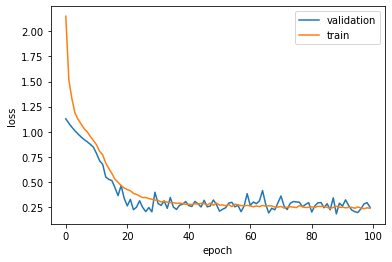

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['validation','train'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
y_pred = model.predict(x_val)
y_pred

array([[ 1.033996  ],
       [ 1.0329183 ],
       [ 1.031457  ],
       ...,
       [-0.32326043],
       [-0.31347114],
       [-0.3073641 ]], dtype=float32)

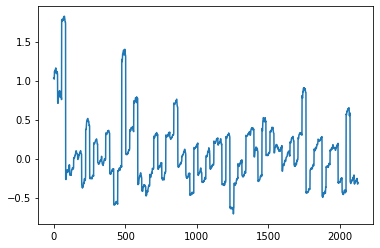

In [ ]:
plt.plot(y_pred)

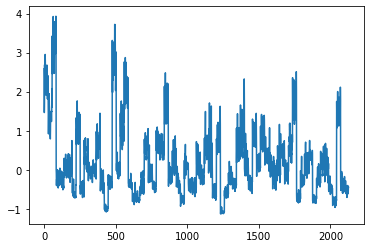

In [ ]:
plt.plot(y_val)

In [ ]:
y_pred_test = model.predict(x_test)
y_pred_test

array([[ 1.0891674 ],
       [ 1.0840518 ],
       [ 1.1176802 ],
       ...,
       [-0.26857412],
       [-0.27540427],
       [-0.28179693]], dtype=float32)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_test)

0.7778285931793402

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_test)

0.15898461642450853

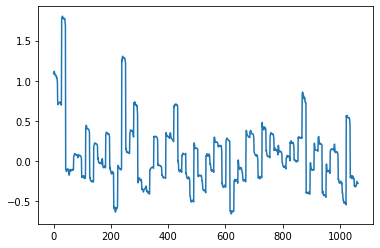

In [ ]:
plt.plot(y_pred_test)

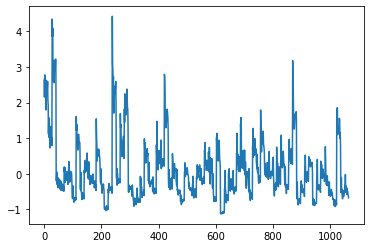

In [ ]:
plt.plot(y_test)

In [ ]:
y_pred_test = y_pred_test.flatten()
y_pred_test.shape

(1064,)

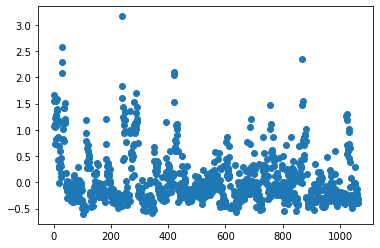

In [ ]:
plt.scatter(range(len(y_test)),y_test-y_pred_test)